In [1]:
from tensorflow import keras
from keras.layers import (Conv2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D,
                          LocallyConnected2D, Dense, Flatten, Dropout, Add)

2022-12-25 20:57:57.890184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 20:57:59.184344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-25 20:57:59.184449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-25 20:57:59.184456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Build the model
activation = 'relu'
input_shape = (28, 28, 1)
kernel = 3
pool = 2
padding = 'valid'

dropout = 0.25

inputs = keras.Input(shape=input_shape)
batch_norm_input = BatchNormalization()(inputs)

# first branch
x = Conv2D(32, kernel_size=kernel, padding=padding, activation=activation)(batch_norm_input)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = Conv2D(64, kernel_size=kernel, padding=padding, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = Conv2D(128, kernel_size=kernel, padding=padding, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)
out_first = Flatten()(x)
print("out first", x.shape)

# second branch
x = SeparableConv2D(32, kernel_size=kernel, padding=padding, activation=activation)(batch_norm_input)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = SeparableConv2D(64, kernel_size=kernel, padding=padding, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = SeparableConv2D(128, kernel_size=kernel, padding=padding, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)
out_second = Flatten()(x)
print("out second", x.shape)

# third branch
x = LocallyConnected2D(32, kernel_size=kernel, activation=activation)(batch_norm_input)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = LocallyConnected2D(64, kernel_size=kernel, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)

x = LocallyConnected2D(128, kernel_size=kernel, activation=activation)(x)
x = MaxPooling2D(2)(x)
x = SpatialDropout2D(dropout)(x)
out_third = Flatten()(x)
print("out third", x.shape)

# fourth branch
x = Flatten()(batch_norm_input)
x = Dense(512, activation=activation)(x)
x = Dropout(dropout)(x)
x = Dense(256, activation=activation)(x)
x = Dropout(dropout)(x)
x = Dense(128, activation=activation)(x)
out_fourth = Dropout(dropout)(x)
print("out forth", x.shape)

y = Add()([out_first, out_second, out_third, out_fourth])

outputs = Dense(10, activation='softmax')(y)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

2022-12-25 20:58:00.865966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 20:58:00.898279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 20:58:00.898472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 20:58:00.898855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

out first (None, 1, 1, 128)
out second (None, 1, 1, 128)
out third (None, 1, 1, 128)
out forth (None, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['batch_normalization[0][0]']    
                                                                                      

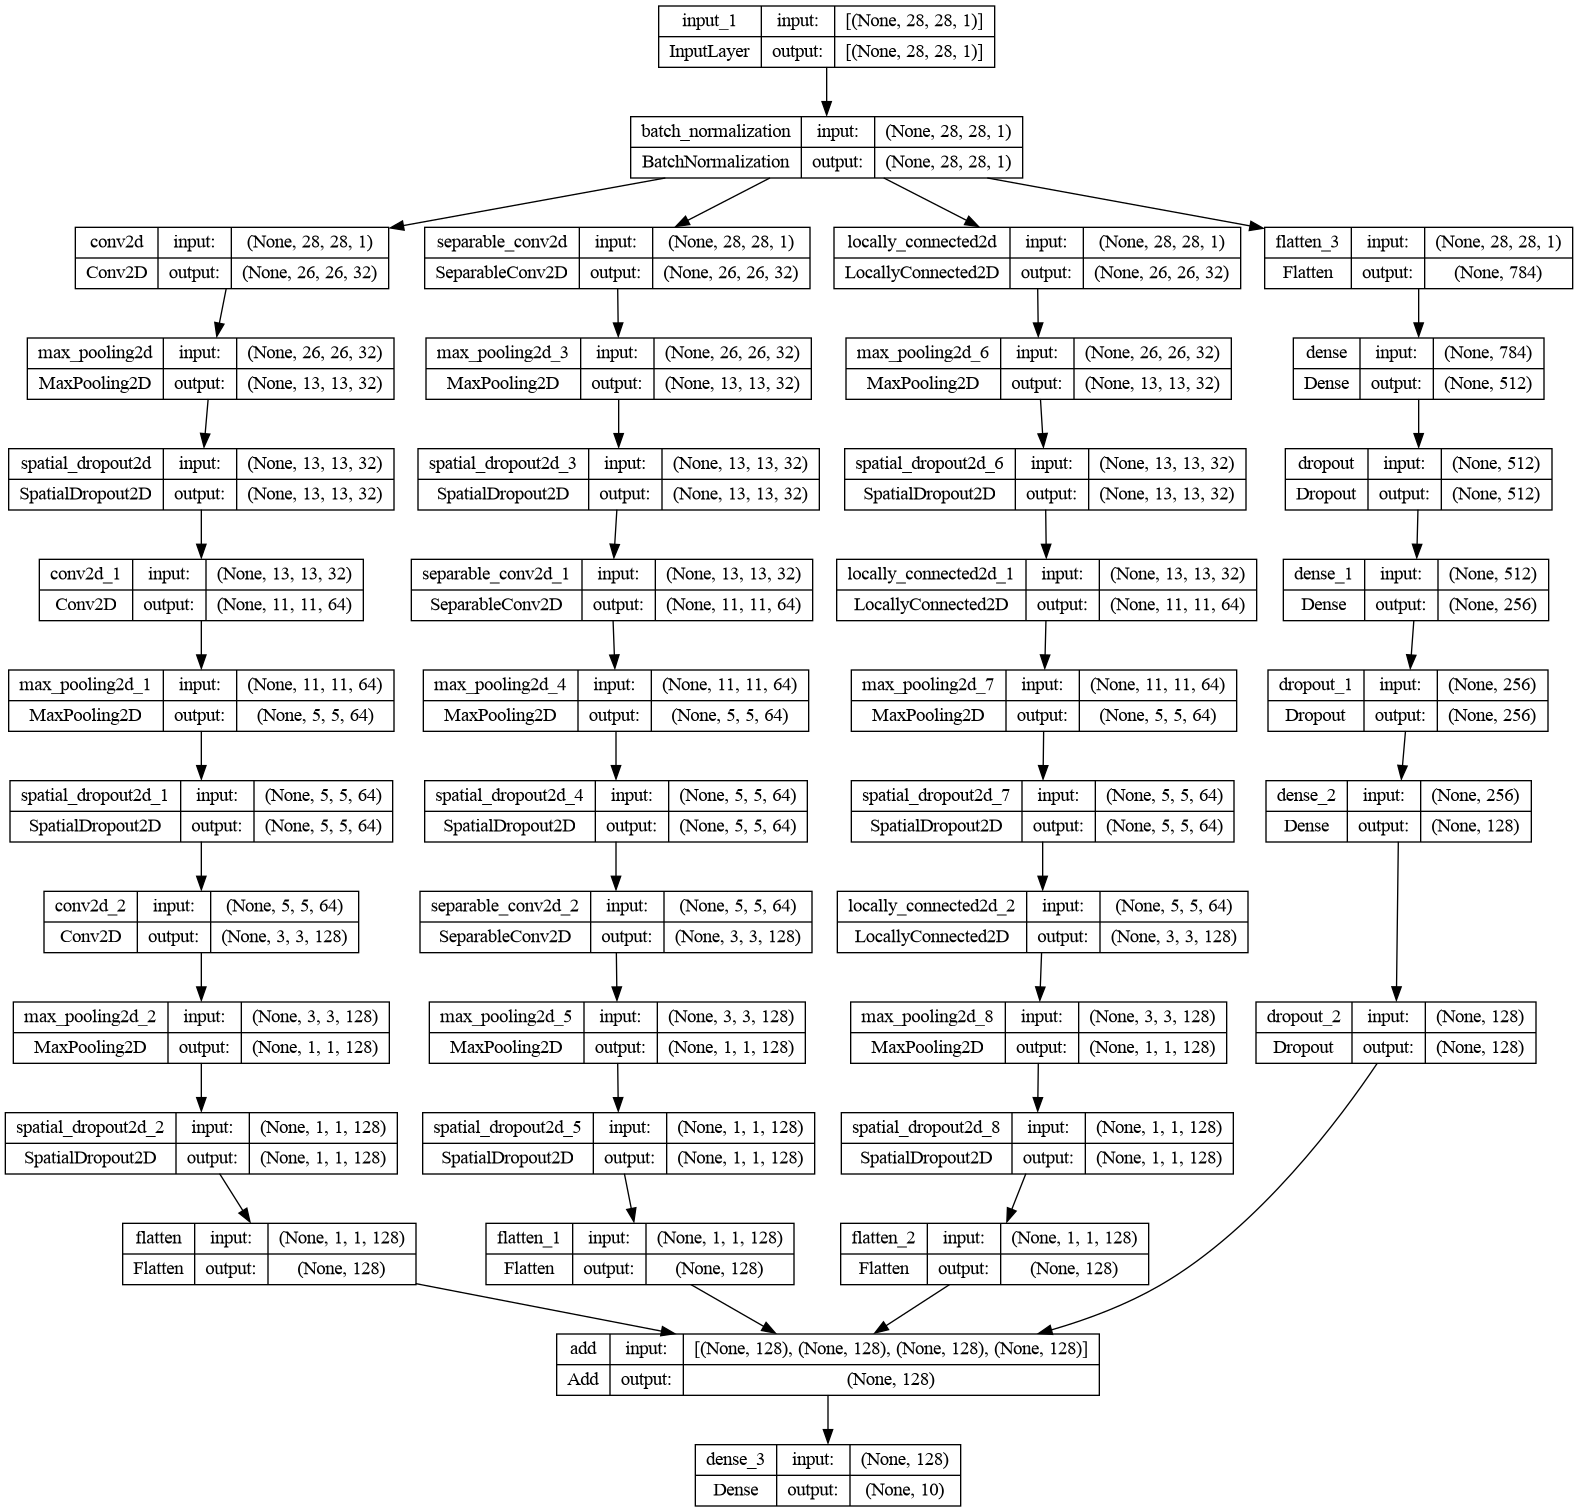

In [3]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

In [4]:
import json
print(json.dumps(model.get_config()))

{"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 28, 28, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0.001, "center": true, "scale": true, "beta_initializer": {"class_name": "Zeros", "config": {}}, "gamma_initializer": {"class_name": "Ones", "config": {}}, "moving_mean_initializer": {"class_name": "Zeros", "config": {}}, "moving_variance_initializer": {"class_name": "Ones", "config": {}}, "beta_regularizer": null, "gamma_regularizer": null, "beta_constraint": null, "gamma_constraint": null}, "name": "batch_normalization", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1

In [5]:
model.get_layer('conv2d').trainable_weights[1]

<tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [18]:
model.get_layer('dense_3')

In [17]:
model.get_layer('dense_3').inbound_nodes[0].inbound_layers

In [23]:
for l in model.layers:
    layer_name = l.name
    print(f"layer: {layer_name}", end=" ")
    for node in l.outbound_nodes:
        print(node.outbound_layer.name, )

layer: input_1 batch_normalization
layer: batch_normalization conv2d
separable_conv2d
locally_connected2d
flatten_3
layer: conv2d max_pooling2d
layer: separable_conv2d max_pooling2d_3
layer: locally_connected2d max_pooling2d_6
layer: max_pooling2d spatial_dropout2d
layer: max_pooling2d_3 spatial_dropout2d_3
layer: max_pooling2d_6 spatial_dropout2d_6
layer: spatial_dropout2d conv2d_1
layer: spatial_dropout2d_3 separable_conv2d_1
layer: spatial_dropout2d_6 locally_connected2d_1
layer: conv2d_1 max_pooling2d_1
layer: separable_conv2d_1 max_pooling2d_4
layer: locally_connected2d_1 max_pooling2d_7
layer: flatten_3 dense
layer: max_pooling2d_1 spatial_dropout2d_1
layer: max_pooling2d_4 spatial_dropout2d_4
layer: max_pooling2d_7 spatial_dropout2d_7
layer: dense dropout
layer: spatial_dropout2d_1 conv2d_2
layer: spatial_dropout2d_4 separable_conv2d_2
layer: spatial_dropout2d_7 locally_connected2d_2
layer: dropout dense_1
layer: conv2d_2 max_pooling2d_2
layer: separable_conv2d_2 max_pooling2d_5